## Setting Up:

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.iceland_preprocess import *
from scripts.plots import *
from scripts.config_ICE import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.IcelandConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)


vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [3]:
if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## A. Read GL data:

In [ ]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'ICE_dataset_all_oggm_with_hugonnetdhdt.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

## Input data:
### Input dataset:

In [ ]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='ICE_dataset_monthly_full_with_hugonnetdhdt.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))
"""
data_monthly['GLWD_ID'] = data_monthly.apply(
    lambda x: mbm.data_processing.utils.get_hash(f"{x.GLACIER}_{x.YEAR}"),
    axis=1)
data_monthly['GLWD_ID'] = data_monthly['GLWD_ID'].astype(str)

dataloader_gl = mbm.dataloader.DataLoader(cfg,
                                          data=data_monthly,
                                          random_seed=cfg.seed,
                                          meta_data_columns=cfg.metaData)
"""

## Blocking on glaciers:

In [ ]:
# These are the two icecaps to the west
Langjokul = dataloader_gl.data[
    (dataloader_gl.data['POINT_LON'] < -19.4) & 
    (dataloader_gl.data['POINT_LAT'] > 64.3)
]['GLACIER'].unique()
display(Langjokul)

In [ ]:
test_glaciers = ['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

In [ ]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

## B. CH Transfer

In [5]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_ICE = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_all_oggm_with_hugonnetdhdt.csv')

# Drop Nan entries in hugonnetdhdt of Iceland dataset
data_ICE = data_ICE.dropna(subset=data_ICE.columns.drop('DATA_MODIFICATION'))
display(data_CH.columns)

display(data_ICE.columns)

data_CH = data_CH.drop(['aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with ICE
data_ICE_CH = pd.concat([data_ICE, data_CH], axis=0).reset_index(drop=True)

display(data_ICE_CH.head(2))

display(len(data_ICE_CH['GLACIER'].unique()))

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'DATA_MODIFICATION',
       'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'GLACIER', 'POINT_ID'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v'],
      dtype='object')

,POINT_ELEVATION,POINT_LAT,POINT_LON,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,GLACIER,POINT_ID
0,1049.6,64.790063,-18.595688,NaN,19880920,19890922,0.45,annual,1989.0,RGI60-06.00234,158.07156,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...
1,1049.4,64.790063,-18.595688,NaN,19890922,19900916,-0.80,annual,1990.0,RGI60-06.00234,158.07156,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...


86

In [6]:
data_CH_ICE_test = data_ICE_CH.copy()

display(data_CH_ICE_test.shape)
display(data_CH_ICE_test.head(2))

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_ICE_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_ICE_wgms_dataset_monthly_full_with_hugonnetdhdt.csv')
data_monthly_CH_ICE = dataloader_gl.data

display(data_monthly_CH_ICE.head(2))

(39288, 18)

,POINT_ELEVATION,POINT_LAT,POINT_LON,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,GLACIER,POINT_ID
0,1049.6,64.790063,-18.595688,NaN,19880920,19890922,0.45,annual,1989.0,RGI60-06.00234,158.07156,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...
1,1049.4,64.790063,-18.595688,NaN,19890922,19900916,-0.80,annual,1990.0,RGI60-06.00234,158.07156,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...


2025-07-07 13:47:18,888 - INFO - Loaded preprocessed data.
2025-07-07 13:47:18,889 - INFO - Number of monthly rows: 346891
2025-07-07 13:47:18,925 - INFO - Number of annual samples: 122355
2025-07-07 13:47:18,958 - INFO - Number of winter samples: 224536


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-4.787933,0.003747,198886.0,590722.0,3990646.0,0.84564,-1779436.0,-0.590102,0.603381
1,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-5.262054,0.003766,306376.0,576896.0,883468.0,0.84690,-1458576.0,0.129348,2.214950


In [7]:
test_glaciers = list(data_ICE['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = list(data_CH['GLACIER'].unique())

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 56209
Size of train data: 290682
Percentage of test size: 19.34%
Train glaciers: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (47) ['Thjorsarjoekull (Hofsjoekull E)' 'Breidamerkurjoekull' 'Dyngjujoekull'
 'RGI60-06.00328' 'Tungnaarjoekull' 'Hagafellsjoekull West'
 'Eyjabakkajoekull' 'RGI60-06.00303' 'Langjoekull Ice Cap'
 'Koeldukvislarjoekull' 'Oeldufellsjoekull' 'Skeidararjoekull'
 'Slettjoekull West' 'RGI60-06.00466' 'RGI60-06.00411' 'RGI60-06.00302'
 'RGI60-06.00359' 'RGI60-06.00340' 'Bruarjoekull'
 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00238' 'RGI60-06.00320'
 'Hagaf

In [19]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

print("Train indices (first 10):", train_indices[:10])
print("Val indices (first 10):", val_indices[:10])
print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train indices (first 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Val indices (first 10): [45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
Train data glacier distribution: GLACIER
rhone        44950
silvretta    35123
findelen     26643
gries        20769
aletsch      13111
Name: count, dtype: int64
Val data glacier distribution: GLACIER
rhone        11123
silvretta     9354
findelen      6914
gries         4934
aletsch       3158
Name: count, dtype: int64
Train data shape: (232646, 29)
Val data shape: (58036, 29)


## Neural Network:

In [ ]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate)

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

# Because CH has some extra columns, we need to cut those
df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (232646, 28)
Shape of validation dataset: (58036, 28)
Shape of testing dataset: (56209, 28)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']
Feature columns:
['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'RGIId', 'POINT_ID', 'ID', 'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'POINT_BALANCE', 'YEAR', 'POINT_LAT', 'POINT_LON', 'ALTITUDE_CLIMATE', 'POINT_ELEVATION']
Number of features: 28


### Initialise network:

In [10]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=10,
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter
def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

custom_params = {
    'lr': 0.001,
    'batch_size': 128,
    'module__layer0': 64,
    'module__layer1': 64,
    'module__layer2': 32,
    'module__layer3': 32,
    'module__dropout': 0.2,
    'optimizer':torch.optim.Adam
}

params = custom_params

args = {
    'module': BiggerNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__layer0': params['module__layer0'],
    'module__layer1': params['module__layer1'],
    'module__layer2': params['module__layer2'],
    'module__layer3': params['module__layer3'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 300,
    'optimizer': params['optimizer'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

### Create datasets:

In [11]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)

train: (26686,) (26686,)
validation: (6672,) (6672,)


### Train custom model:

In [18]:
TRAIN = False
if TRAIN:
    custom_nn.seed_all()

    print("Training the model...")
    print('Model parameters:')
    for key, value in args.items():
        print(f"{key}: {value}")
    custom_nn.fit(dataset.X, dataset.y)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"nn_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # After Training: Best weights are already loaded
    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"nn_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump(args, f)

else:
    # Load model and set to CPU
    model_filename = "nn_model_2025-07-07_CH_with_hugonnetdhdt.pt"  # Replace with actual date if needed
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg,
        model_filename,
        **{
            **args,
            **param_init
        },
    )
    loaded_model = loaded_model.set_params(device='cpu')
    loaded_model = loaded_model.to('cpu')

### Load model and make predictions:

In [15]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

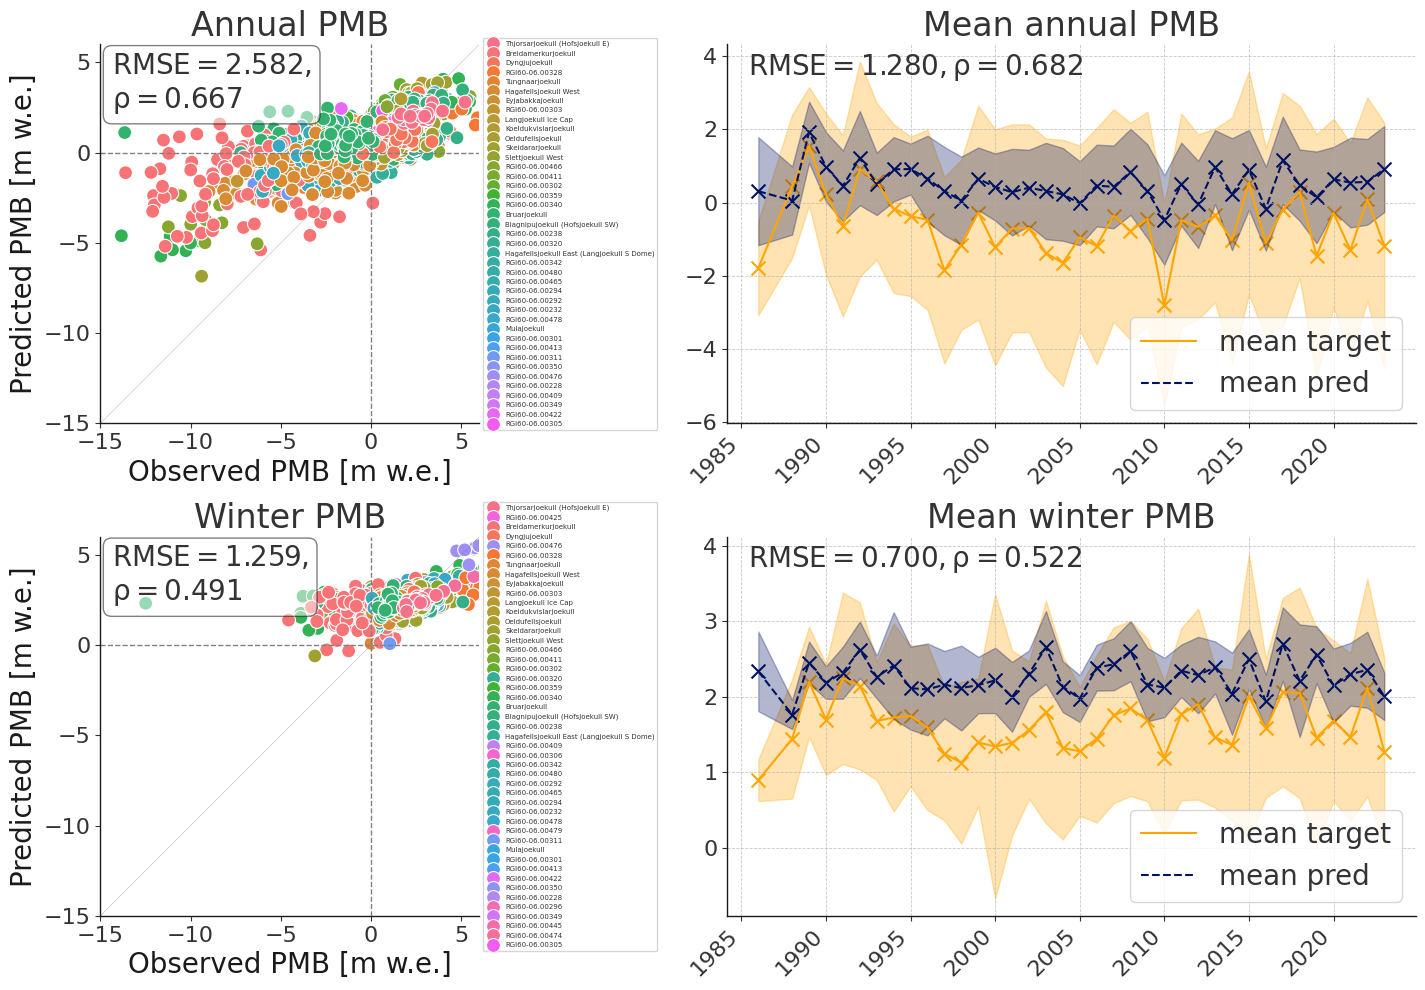

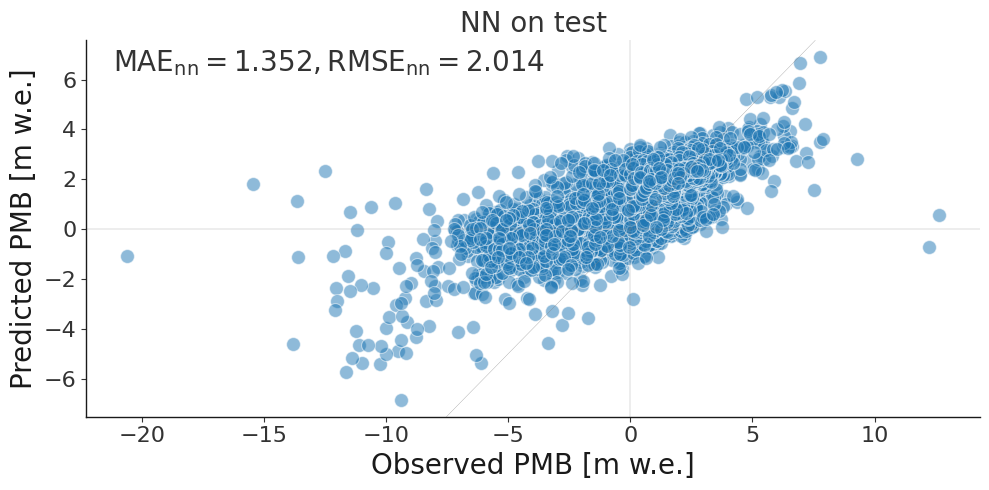

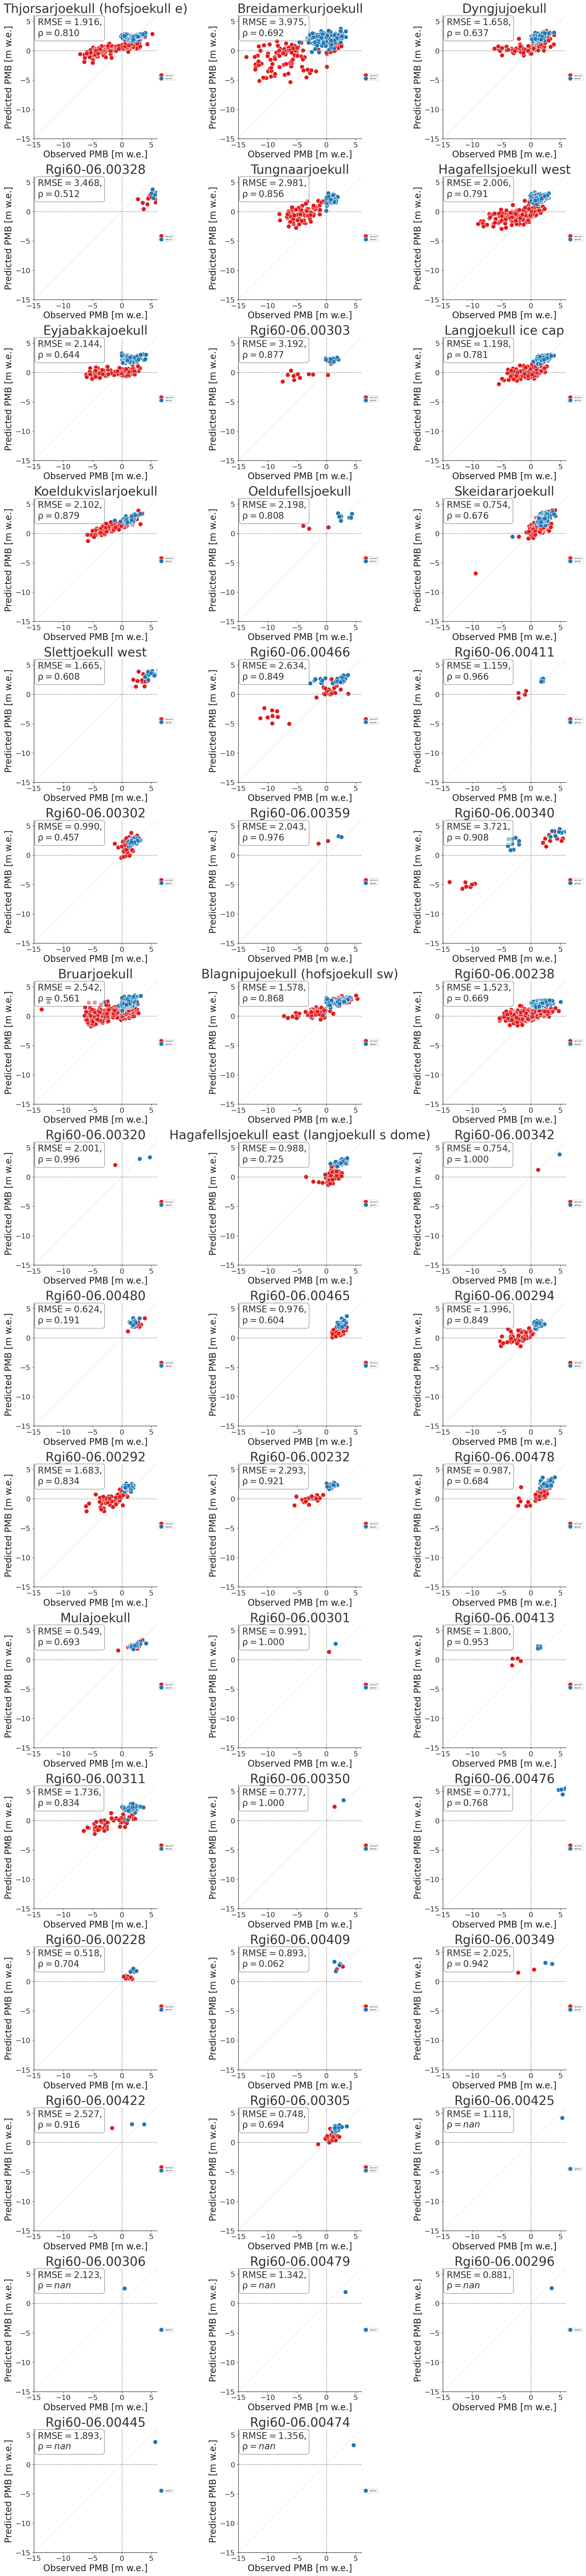

In [16]:
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae, rmse, title='NN on test')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))